In [1]:
#https://www.hatarilabs.com/ih-en/basic-example-of-saline-intrusion-modeling-seawat-and-flopy
%matplotlib inline
import os
import sys
import numpy as np
import flopy
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import ipywidgets as widgets

flopy is installed in C:\Users\Chelsea\Anaconda3\lib\site-packages\flopy


In [2]:
# Create the basic MODFLOW model structure
modelname = 'model1a'
workspace = '../Model'
#ws = 'data/ex01a' #workspace
exe_name = os.path.abspath('../bin/swtv4')
swt = flopy.seawat.Seawat(modelname, exe_name=exe_name, model_ws=workspace)
print(swt.namefile)

model1a.nam


In [3]:
print(exe_name)

C:\Users\Chelsea\Documents\Projects\DelawareStream\FloPy\bin\swtv4


In [4]:
#This model is almost a 2D model of 100 columns, 50 layers and 1 row. Total dimension in X, Y and Z axis are 2, 1 and 1 meter repectively.# Model dimensions
Lx = 2.
Ly = 1.
Lz = 1.

# Spatial discretization
nlay = 50 #num of layer
nrow = 1 #num of rows
ncol = 100 #num of cols
delr = Lx / ncol
delc = Ly
delv = Lz / nlay

# Elevation for model surface and layer bottom elevation
model_top = 1.
model_botm = np.linspace(model_top - delv, 0., nlay)

model_botm

array([0.98, 0.96, 0.94, 0.92, 0.9 , 0.88, 0.86, 0.84, 0.82, 0.8 , 0.78,
       0.76, 0.74, 0.72, 0.7 , 0.68, 0.66, 0.64, 0.62, 0.6 , 0.58, 0.56,
       0.54, 0.52, 0.5 , 0.48, 0.46, 0.44, 0.42, 0.4 , 0.38, 0.36, 0.34,
       0.32, 0.3 , 0.28, 0.26, 0.24, 0.22, 0.2 , 0.18, 0.16, 0.14, 0.12,
       0.1 , 0.08, 0.06, 0.04, 0.02, 0.  ])

In [5]:
# Other parameters
qinflow = 6.6E-5 # m3/s equiv to 5.702 m3/day
dmcoef = 6.6E-6 # m2/s equiv to 0.57024 m2/day  Could also try 1.62925 as another case of the Henry problem
hk = 0.01 # m/s equivalent to 864m/day

In [6]:
perlen = 86400 # 1 day in seconds 

dis = flopy.modflow.ModflowDis(swt, nlay, nrow, ncol, nper=1, delr=delr,
                               delc=delc, laycbd=0, top=model_top,
                               botm=model_botm, perlen=perlen, nstp=15)

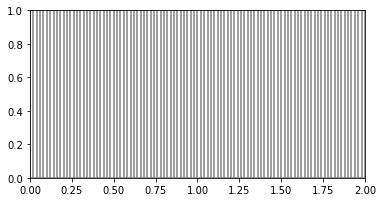

In [7]:
mm = flopy.plot.PlotMapView(model = swt)
mm.plot_grid()

In [71]:
# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, -1] = -1
bas = flopy.modflow.ModflowBas(swt, ibound, 0)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(swt, hk=hk, vka=hk, ipakcb=53)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(swt, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(swt, 
                             stress_period_data={(0, 0): ['save head', 'save budget']},
                             compact=True)

In [72]:
# Create WEL and SSM data
itype = flopy.mt3d.Mt3dSsm.itype_dict()
wel_data = {}
ssm_data = {}
wel_sp1 = []
ssm_sp1 = []
for k in range(nlay):
    wel_sp1.append([k, 0, 0, qinflow / nlay])
    ssm_sp1.append([k, 0, 0, 0., itype['WEL']])
    ssm_sp1.append([k, 0, ncol - 1, 35., itype['BAS6']])
wel_data[0] = wel_sp1
ssm_data[0] = ssm_sp1
wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_data, ipakcb=53)

In [109]:
# layer row col stage conductance bottom
riv_data = [(0, 0, 19, .20, 6.6E-4, .18)] #The river is located in layer 1 and column 20 in every row 
#in the model. The river stage stage and bottom are at 320 and 318, respectively; the river conductance is 1e5.
riv = flopy.modflow.ModflowRiv(swt, stress_period_data = {0: riv_data})

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfriv.ModflowRiv'> <class 'flopy.modflow.mfriv.ModflowRiv'>
replacing existing Package...


A well is created with the WEL package and defined as a source of fresh water with concentration of 0. The left boundary is defined as sea water with concentration of 35. The well inflow is distributed over the model layers.

In [110]:
# Create the basic MT3DMS model structure
btn = flopy.mt3d.Mt3dBtn(swt, nprs=-5, prsity=0.35, sconc=35., ifmtcn=0,
                         chkmas=False, nprobs=10, nprmas=10, dt0=300)
adv = flopy.mt3d.Mt3dAdv(swt, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(swt, al=0., trpt=1., trpv=1., dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=500, mxiter=1, isolve=1, cclose=1e-7)
ssm = flopy.mt3d.Mt3dSsm(swt, stress_period_data=ssm_data)

# Create the SEAWAT model structure
vdf = flopy.seawat.SeawatVdf(swt, iwtable=0, densemin=0, densemax=0,
                             denseref=1000., denseslp=0.7143, firstdt=1e-3)

****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtbtn.Mt3dBtn'> <class 'flopy.mt3d.mtbtn.Mt3dBtn'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtadv.Mt3dAdv'> <class 'flopy.mt3d.mtadv.Mt3dAdv'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtdsp.Mt3dDsp'> <class 'flopy.mt3d.mtdsp.Mt3dDsp'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtgcg.Mt3dGcg'> <class 'flopy.mt3d.mtgcg.Mt3dGcg'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtssm.Mt3dSsm'> <class 'flopy.mt3d.mtssm.Mt3dSsm'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.seawat.swtvdf.SeawatVdf'> <class 'flopy.seawat.swtvdf.SeawatVdf'>
replacing existing Package...


In [111]:
# Write the input files
swt.write_input()
swt.run_model()

FloPy is using the following  executable to run the model: C:\Users\cnpeters\Documents\Projects\DelawareStream\FloPy\bin\swtv4.exe

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: model1a.nam                                                                                                                                                                                             
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/06/10 16:49:47

 Outer Iter.  1  Inner Iter. 44:  Max. DC =  0.9457E-04  [K,I,J]   11    1   38
 Outer Iter.  1  Inner Iter. 45:  Max. DC =  0.9785E-03  [K,I,J]   11    1   39
 Outer Iter.  1  Inner Iter. 46:  Max. DC =  0.5030E-03  [K,I,J]    5    1   46
 Outer Iter.  1  Inner Iter. 47:  Max. DC =  0.3642E-03  [K,I,J]    5    1   47
 Outer Iter.  1  Inner Iter. 48:  Max. DC =  0.5623E-03  [K,I,J]   11    1   38
 Outer Iter.  1  Inner Iter. 49:  Max. DC =  0.6516E-04  [K,I,J]   11    1   38
 Outer Iter.  1  Inner Iter. 50:  Max. DC =  0.1019E-04  [K,I,J]    6    1   54
 Outer Iter.  1  Inner Iter. 51:  Max. DC =  0.7792E-04  [K,I,J]   14    1   39
 Outer Iter.  1  Inner Iter. 52:  Max. DC =  0.7717E-06  [K,I,J]   17    1   45
 Outer Iter.  1  Inner Iter. 53:  Max. DC =  0.1400E-04  [K,I,J]    4    1   55
 Outer Iter.  1  Inner Iter. 54:  Max. DC =  0.3452E-03  [K,I,J]   16    1   42
 Outer Iter.  1  Inner Iter. 55:  Max. DC =  0.1198E-03  [K,I,J]   17    1   43
 Outer Iter.  1  Inner Iter. 56:  Max. D

 Outer Iter.  1  Inner Iter. 17:  Max. DC =  0.4372E-02  [K,I,J]   50    1   10
 Outer Iter.  1  Inner Iter. 18:  Max. DC =  0.1391E-02  [K,I,J]   50    1   11
 Outer Iter.  1  Inner Iter. 19:  Max. DC =  0.1918E-03  [K,I,J]   42    1    9
 Outer Iter.  1  Inner Iter. 20:  Max. DC =  0.8935E-03  [K,I,J]   41    1   11
 Outer Iter.  1  Inner Iter. 21:  Max. DC =  0.1501E-02  [K,I,J]   42    1   12
 Outer Iter.  1  Inner Iter. 22:  Max. DC =  0.9870E-04  [K,I,J]   41    1   10
 Outer Iter.  1  Inner Iter. 23:  Max. DC =  0.1186E-03  [K,I,J]   39    1   12
 Outer Iter.  1  Inner Iter. 24:  Max. DC =  0.1821E-06  [K,I,J]   40    1   13
 Outer Iter.  1  Inner Iter. 25:  Max. DC =  0.2752E-03  [K,I,J]   39    1   12
 Outer Iter.  1  Inner Iter. 26:  Max. DC =  0.5088E-04  [K,I,J]   41    1   10
 Outer Iter.  1  Inner Iter. 27:  Max. DC =  0.5077E-04  [K,I,J]   41    1   11
 Outer Iter.  1  Inner Iter. 28:  Max. DC =  0.6125E-04  [K,I,J]   43    1   11
 Outer Iter.  1  Inner Iter. 29:  Max. D

 Outer Iter.  1  Inner Iter. 40:  Max. DC =  0.1752E-05  [K,I,J]   42    1   91
 Outer Iter.  1  Inner Iter. 41:  Max. DC =  0.2124E-05  [K,I,J]   38    1   28
 Outer Iter.  1  Inner Iter. 42:  Max. DC =  0.1913E-06  [K,I,J]   38    1   27
 Outer Iter.  1  Inner Iter. 43:  Max. DC =  0.2798E-05  [K,I,J]   39    1   29
 Outer Iter.  1  Inner Iter. 44:  Max. DC =  0.4461E-05  [K,I,J]   39    1   29
 Outer Iter.  1  Inner Iter. 45:  Max. DC =  0.6214E-05  [K,I,J]   38    1   28
 Outer Iter.  1  Inner Iter. 46:  Max. DC =  0.5314E-06  [K,I,J]   42    1   92
 Outer Iter.  1  Inner Iter. 47:  Max. DC =  0.1214E-05  [K,I,J]   42    1   92
 Outer Iter.  1  Inner Iter. 48:  Max. DC =  0.1013E-05  [K,I,J]   38    1   27
 Outer Iter.  1  Inner Iter. 49:  Max. DC =  0.3165E-06  [K,I,J]   39    1   25
 Outer Iter.  1  Inner Iter. 50:  Max. DC =  0.7367E-06  [K,I,J]   39    1   26
 Outer Iter.  1  Inner Iter. 51:  Max. DC =  0.6321E-06  [K,I,J]   38    1   27
 Outer Iter.  1  Inner Iter. 52:  Max. D

 Outer Iter.  1  Inner Iter. 24:  Max. DC =  0.1878E-04  [K,I,J]   16    1   99
 Outer Iter.  1  Inner Iter. 25:  Max. DC =  0.4026E-04  [K,I,J]   16    1   99
 Outer Iter.  1  Inner Iter. 26:  Max. DC =  0.2365E-04  [K,I,J]   36    1   55
 Outer Iter.  1  Inner Iter. 27:  Max. DC =  0.1228E-03  [K,I,J]   17    1   99
 Outer Iter.  1  Inner Iter. 28:  Max. DC =  0.1324E-03  [K,I,J]   17    1   99
 Outer Iter.  1  Inner Iter. 29:  Max. DC =  0.3508E-05  [K,I,J]   10    1  100
 Outer Iter.  1  Inner Iter. 30:  Max. DC =  0.1682E-04  [K,I,J]   36    1   48
 Outer Iter.  1  Inner Iter. 31:  Max. DC =  0.1419E-04  [K,I,J]    9    1  100
 Outer Iter.  1  Inner Iter. 32:  Max. DC =  0.6170E-05  [K,I,J]   10    1  100
 Outer Iter.  1  Inner Iter. 33:  Max. DC =  0.1308E-04  [K,I,J]   12    1   99
 Outer Iter.  1  Inner Iter. 34:  Max. DC =  0.6472E-05  [K,I,J]   12    1  100
 Outer Iter.  1  Inner Iter. 35:  Max. DC =  0.1012E-04  [K,I,J]   12    1  100
 Outer Iter.  1  Inner Iter. 36:  Max. D

 Outer Iter.  1  Inner Iter. 25:  Max. DC =  0.2550E-03  [K,I,J]   11    1  100
 Outer Iter.  1  Inner Iter. 26:  Max. DC =  0.1132E-03  [K,I,J]   11    1  100
 Outer Iter.  1  Inner Iter. 27:  Max. DC =  0.5199E-04  [K,I,J]   11    1  100
 Outer Iter.  1  Inner Iter. 28:  Max. DC =  0.1317E-03  [K,I,J]   10    1   99
 Outer Iter.  1  Inner Iter. 29:  Max. DC =  0.9572E-05  [K,I,J]    9    1   99
 Outer Iter.  1  Inner Iter. 30:  Max. DC =  0.1169E-04  [K,I,J]   10    1  100
 Outer Iter.  1  Inner Iter. 31:  Max. DC =  0.4850E-05  [K,I,J]    9    1  100
 Outer Iter.  1  Inner Iter. 32:  Max. DC =  0.2858E-05  [K,I,J]   11    1  100
 Outer Iter.  1  Inner Iter. 33:  Max. DC =  0.4439E-05  [K,I,J]    9    1  100
 Outer Iter.  1  Inner Iter. 34:  Max. DC =  0.1040E-05  [K,I,J]   10    1  100
 Outer Iter.  1  Inner Iter. 35:  Max. DC =  0.3144E-05  [K,I,J]   13    1  100
 Outer Iter.  1  Inner Iter. 36:  Max. DC =  0.3271E-05  [K,I,J]   10    1  100
 Outer Iter.  1  Inner Iter. 37:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1482E-02  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7436E-03  [K,I,J]   26    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3387E-03  [K,I,J]   27    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1568E-03  [K,I,J]   28    1  100
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1187E-03  [K,I,J]   28    1   99
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.8031E-04  [K,I,J]   23    1   98
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6104E-04  [K,I,J]   29    1   98
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.4285E-04  [K,I,J]   21    1   98
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.2673E-04  [K,I,J]   21    1   97
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.1681E-04  [K,I,J]   20    1   97
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.9003E-05  [K,I,J]    9    1   99
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.4961E-05  [K,I,J]    8    1  100
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7953E-04  [K,I,J]   50    1   55
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3637E-04  [K,I,J]   50    1   54
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2397E-04  [K,I,J]   50    1   58
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2377E-04  [K,I,J]   49    1   57
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.1745E-04  [K,I,J]   48    1   57
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.1188E-04  [K,I,J]   48    1   58
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.1042E-04  [K,I,J]   47    1   58
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6693E-05  [K,I,J]   46    1   58
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.5409E-05  [K,I,J]   46    1   59
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.4011E-05  [K,I,J]   45    1   59
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.2976E-05  [K,I,J]   45    1   60
 Outer Iter.  1  Inner Iter. 13:  Max. DC =  0.2419E-05  [K,I,J]   44    1   60
 Outer Iter.  1  Inner Iter. 14:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.2459E-05  [K,I,J]   49    1   96
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.1745E-05  [K,I,J]   49    1   95
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.1283E-05  [K,I,J]   50    1   95
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.1184E-05  [K,I,J]   50    1   94
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.1018E-05  [K,I,J]   50    1   93
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.7955E-06  [K,I,J]   50    1   92
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.6150E-06  [K,I,J]   50    1   91
 Outer Iter.  1  Inner Iter. 13:  Max. DC =  0.4397E-06  [K,I,J]   50    1   90
 Outer Iter.  1  Inner Iter. 14:  Max. DC =  0.3407E-06  [K,I,J]    4    1  100
 Outer Iter.  1  Inner Iter. 15:  Max. DC =  0.1233E-06  [K,I,J]    3    1  100
 Outer Iter.  1  Inner Iter. 16:  Max. DC =  0.2310E-06  [K,I,J]    2    1  100
 Outer Iter.  1  Inner Iter. 17:  Max. DC =  0.3458E-04  [K,I,J]    4    1  100
 Outer Iter.  1  Inner Iter. 18:  Max. D

 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.9157E-06  [K,I,J]   47    1   92
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.2213E-05  [K,I,J]   47    1   92
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.8170E-06  [K,I,J]   47    1   88
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.7344E-06  [K,I,J]   46    1   88
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.5305E-06  [K,I,J]   45    1   91
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.1170E-05  [K,I,J]   45    1   91
 Outer Iter.  1  Inner Iter. 13:  Max. DC =  0.2898E-06  [K,I,J]   44    1   88
 Outer Iter.  1  Inner Iter. 14:  Max. DC =  0.1605E-06  [K,I,J]   50    1   94
 Outer Iter.  1  Inner Iter. 15:  Max. DC =  0.1001E-06  [K,I,J]   48    1   93
 Outer Iter.  1  Inner Iter. 16:  Max. DC =  0.8600E-07  [K,I,J]   44    1   90
 Transport Step:    7   Step Size:   300.0     Total Elapsed Time:   42420.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3815E-04  [K,I,J]   50    1   86
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.1271E-05  [K,I,J]   49    1   96
 Outer Iter.  1  Inner Iter. 13:  Max. DC =  0.3069E-06  [K,I,J]   48    1   94
 Outer Iter.  1  Inner Iter. 14:  Max. DC =  0.3780E-06  [K,I,J]   49    1   96
 Outer Iter.  1  Inner Iter. 15:  Max. DC =  0.3811E-06  [K,I,J]   50    1   93
 Outer Iter.  1  Inner Iter. 16:  Max. DC =  0.1395E-06  [K,I,J]   47    1   92
 Outer Iter.  1  Inner Iter. 17:  Max. DC =  0.9038E-07  [K,I,J]   49    1   91
 Transport Step:   19   Step Size:   300.0     Total Elapsed Time:   51780.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2325E-04  [K,I,J]   50    1   97
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1264E-04  [K,I,J]   50    1   98
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8821E-05  [K,I,J]   50    1   97
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5302E-05  [K,I,J]   50    1   96
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3810E-05  [K,I,J]   50    1   95
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6516E-05  [K,I,J]   50    1  100
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4234E-05  [K,I,J]   50    1   99
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2445E-05  [K,I,J]   50    1   98
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1899E-05  [K,I,J]   49    1   98
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.1539E-05  [K,I,J]   49    1   97
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.1269E-05  [K,I,J]   49    1   96
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.8059E-06  [K,I,J]   49    1   95
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.5367E-06  [K,I,J]   48    1   95
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.3935E-06  [K,I,J]   48    1   94
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.3046E-06  [K,I,J]   47    1   94
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.2500E-06  [K,I,J]   47    1   93
 Outer Iter.  1  Inner Iter. 13:  Max. DC =  0.1981E-06  [K,I,J]   46    1   93
 Outer Iter.  1  Inner Iter. 14:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9241E-05  [K,I,J]   50    1   93
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6083E-05  [K,I,J]   48    1   91
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5543E-05  [K,I,J]   50    1  100
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2917E-05  [K,I,J]   49    1   98
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1879E-05  [K,I,J]   50    1   97
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.1348E-05  [K,I,J]   50    1   96
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.1253E-05  [K,I,J]   49    1   96
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.9532E-06  [K,I,J]   49    1   95
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.6822E-06  [K,I,J]   48    1   95
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.5856E-06  [K,I,J]   48    1   94
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.4132E-06  [K,I,J]   48    1   93
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.3047E-06  [K,I,J]   47    1   93
 Outer Iter.  1  Inner Iter. 13:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.1395E-05  [K,I,J]   49    1   95
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.1242E-05  [K,I,J]   49    1   94
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.9203E-06  [K,I,J]   49    1   93
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.5418E-06  [K,I,J]   49    1   92
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.3305E-06  [K,I,J]   49    1   91
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.2022E-06  [K,I,J]   50    1   91
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.1459E-06  [K,I,J]   50    1   90
 Outer Iter.  1  Inner Iter. 13:  Max. DC =  0.8472E-07  [K,I,J]   50    1   89
 Transport Step:    9   Step Size:   300.0     Total Elapsed Time:   77580.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8236E-05  [K,I,J]   44    1   99
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4462E-05  [K,I,J]   50    1   99
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3234E-05  [K,I,J]   50    1   99
 Outer Iter.  1  Inner Iter.  4:  Max. D

(True, [])

This tutorial has three representations of the flow and transport model with SEAWAT:

The first representation is a flow direction vector over the concentrations at the end of the model
Second representation is the head distribution on the model extension
Third representation is a interactive graph of concentration development along the model time steps.
1. Flow directions and concentrations

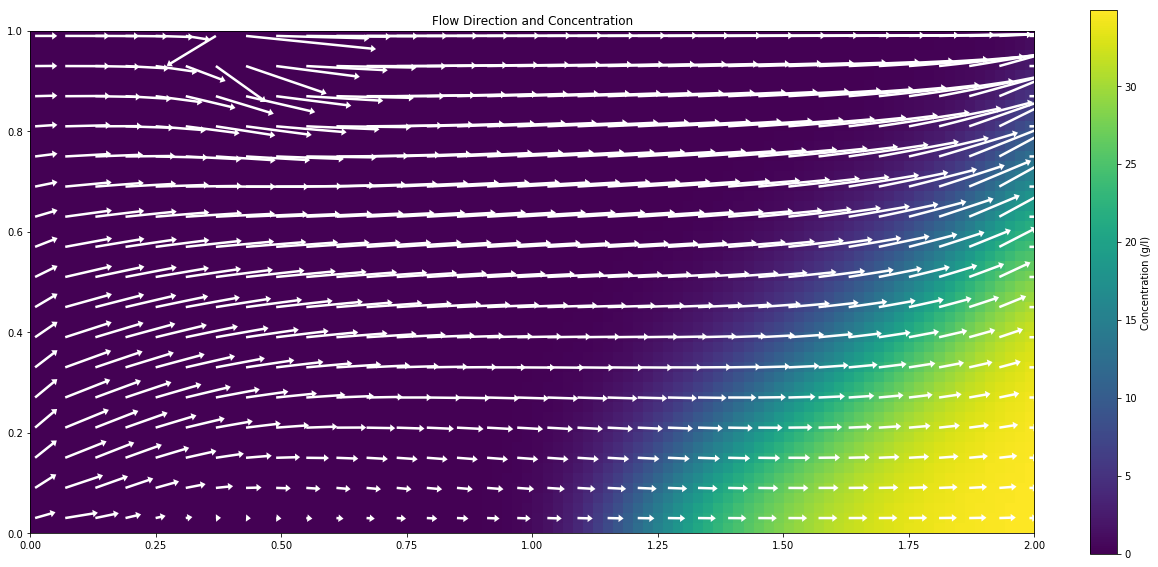

In [112]:
# Load data
ucnobj = bf.UcnFile('../Model/MT3D001.UCN', model=swt)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])
cbbobj = bf.CellBudgetFile('../Model/model1a.cbc')
times = cbbobj.get_times()
qx = cbbobj.get_data(text='flow right face', totim=times[-1])[0]
qz = cbbobj.get_data(text='flow lower face', totim=times[-1])[0]

# Average flows to cell centers
qx_avg = np.empty(qx.shape, dtype=qx.dtype)
qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
qz_avg = np.empty(qz.shape, dtype=qz.dtype)
qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * qz[0, :, :]
# parameters for the colorbar
levels = MaxNLocator(nbins=15).tick_values(concentration.min(), concentration.max())
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# Make the plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
im = ax.imshow(concentration[:, 0, :], interpolation='nearest',
           extent=(0, Lx, 0, Lz))
fig.colorbar(im, ax=ax, fraction=0.05, label="Concentration (g/l)")

y, x, z = dis.get_node_coordinates()
X, Z = np.meshgrid(x, z[:, 0, 0])
iskip = 3
ax.quiver(X[::iskip, ::iskip], Z[::iskip, ::iskip],
           qx_avg[::iskip, 0, ::iskip]*1E5, -qz_avg[::iskip, 0, ::iskip]*1E5,
           color='w', scale=3, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)

ax.set_title('Flow Direction and Concentration')
plt.savefig('../Model/ConcentrationDistribution.png')

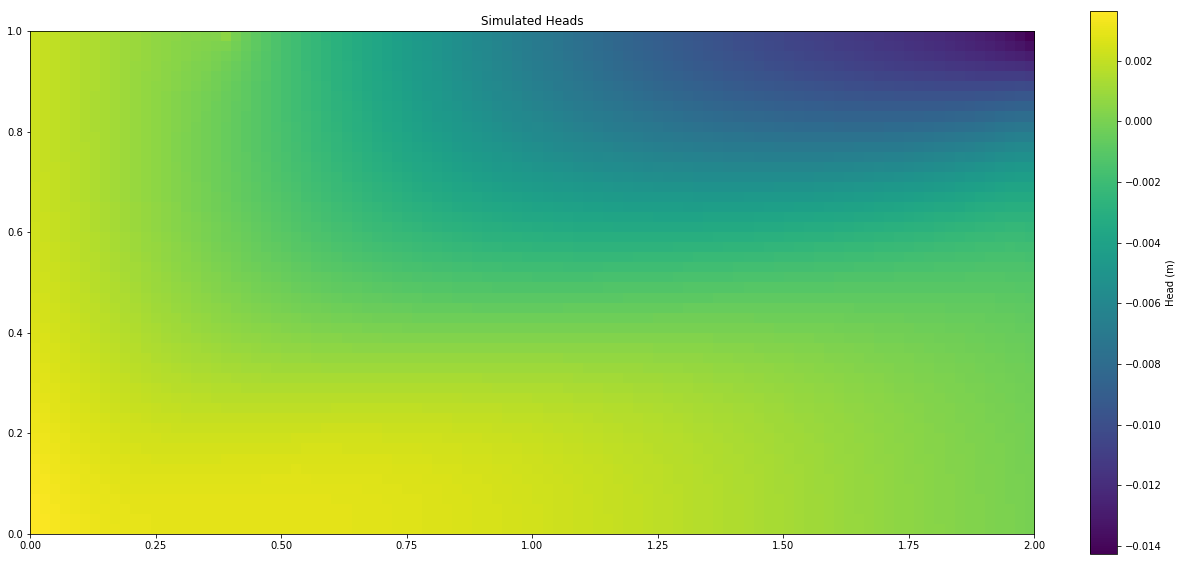

In [113]:
# Extract the heads
fname = '../Model/model1a.hds'
headobj = bf.HeadFile(fname)
times = headobj.get_times()
head = headobj.get_data(totim=times[-1])
head[0:3,0,0:3]

levels = MaxNLocator(nbins=15).tick_values(head.min(), head.max())
cmap = plt.get_cmap('Blues')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# Make a simple head plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
im = ax.imshow(head[:, 0, :], interpolation='nearest',
               extent=(0, Lx, 0, Lz))
fig.colorbar(im, ax=ax, fraction=0.05, label="Head (m)")
ax.set_title('Simulated Heads')
plt.savefig('../Model/HeadDistribution.png')

In [114]:
times = np.asarray(ucnobj.get_times())
times[:5]

def plotConcentration(time):
    # Load data
    ucnobj = bf.UcnFile('../Model/MT3D001.UCN', model=swt)

    concentration = ucnobj.get_data(totim=time)

    # For colormap
    levels = MaxNLocator(nbins=15).tick_values(concentration.min(), concentration.max())
    cmap = plt.get_cmap('PiYG')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    #Figure definition
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
    im = ax.imshow(concentration[:, 0, :], interpolation='nearest',
               extent=(0, Lx, 0, Lz))

    cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])

    fig.colorbar(im, ax=ax, fraction=0.05, label="Concentration (g/l)", cax = cbaxes)
# create a model interactive representation
widgets.interact(plotConcentration, time=widgets.SelectionSlider(options=times, value=times[0], disabled=False))

interactive(children=(SelectionSlider(description='time', options=(1500.0, 3000.0, 4500.0, 5760.0, 7260.0, 876…

<function __main__.plotConcentration(time)>